<a href="https://colab.research.google.com/github/NaHyeonMaeng/Study/blob/main/%ED%8F%AC%EC%BC%93%EB%AA%AC_%EC%98%A4%ED%86%A0%EC%9D%B8%EC%BD%94%EB%8D%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#라이브러리 설정
import numpy as np
import cv2
import os
import glob
import gc
import random
from pathlib import Path

#구글 드라이브 폴더 마운트
from google.colab import drive, files
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
#opencv 라이브러리 활용 및 이미지 편집
img_dir = "/gdrive/My Drive/pokemon/images" # 경로 지정
dim = 64 # 이미지를 64차원으로 설정
X = [] # 이미지 차원 리스트
y = [] # 포켓몬 이름 리스트
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path) # 이미지 경로에 해당하는 파일 불러오기
n=0
for f1 in files:
    try:
        n=n+1
        img = cv2.imread(f1) # 이미지 파일 읽기
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # RGB 컬러 변환
        img = cv2.resize(img, (dim,dim)) # 이미지 크기 조정
        X.append(np.array(img)) # 이미지를 넘파이로 변환후 추가
        y.append(Path(f1).stem) # 포켓몬 이름 추가
    except :
        continue
print(n,' images lues')

# 이미지 및 포켓몬 이름을 넘파이 배열로 변환
X = np.array(X)
y = np.array(y)
gc.collect() # Garbage Collector(필요없는 메모리 해제)

809  images lues


6

salazzle
(64, 64, 3)


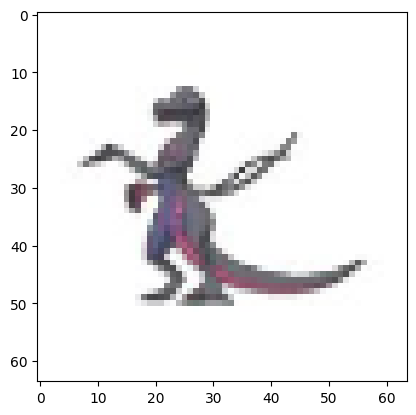

In [3]:
from matplotlib import pyplot as plt

# X에서 무작위로 추출한 이미지
randomIndex = random.randint(0, len(X)-1)

# 포켓몬 이미지와 이름 표시
plt.imshow(X[randomIndex])
print(y[randomIndex])
print(X[randomIndex].shape)

In [4]:
# 600개의 이미지 활용하여 train 데이터 할당
X_train = X[:600]
y_train = y[:600]

# 나머지 209개의 이미지를 활용하여 test 데이터 할당
X_test = X[600:]
y_test = y[600:]

# 이미지 타입 변환 및 피처스케일링 실행
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

In [5]:
# Autoencoder 모델 생성
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, UpSampling2D, MaxPooling2D
from tensorflow.keras.models import Model

input_img = Input(shape=(64,64,3))

# Encode
encoded = Conv2D(256, (3, 3), name='e0' , activation='relu', padding='same')(input_img)
encoded = Conv2D(128, (3, 3), name='e1' , activation='relu', padding='same')(encoded)
encoded = Conv2D(128, (3, 3), name='e2' , activation='relu', padding='same')(encoded)
encoded = MaxPooling2D(pool_size=(2, 2))(encoded)

encoded = Conv2D(64, (3, 3), name='e3' , activation='relu', padding='same')(encoded)
encoded = Conv2D(32, (3, 3), name='e4' , activation='relu', padding='same')(encoded)
encoded = Conv2D(32, (3, 3), name='e5' , activation='relu', padding='same')(encoded)
encoded = MaxPooling2D(pool_size=(2, 2))(encoded)

# Decode
decoded = Conv2D(32, (3, 3), name='d2' , activation='relu', padding='same')(encoded)
decoded = Conv2D(64, (3, 3), name='d3' , activation='relu', padding='same')(decoded)
decoded = UpSampling2D(size=(2,2), name='d4')(decoded)

decoded = Conv2D(128, (3, 3), name='d5' , activation='relu', padding='same')(decoded)
decoded = Conv2D(256, (3, 3), name='d6' , activation='relu', padding='same')(decoded)

decoded = UpSampling2D(size=(2,2), name='d7')(decoded)

decoded = Conv2D(3, (3, 3), name='d8' , activation='sigmoid', padding='same')(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 e0 (Conv2D)                 (None, 64, 64, 256)       7168      
                                                                 
 e1 (Conv2D)                 (None, 64, 64, 128)       295040    
                                                                 
 e2 (Conv2D)                 (None, 64, 64, 128)       147584    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 128)      0         
 )                                                               
                                                                 
 e3 (Conv2D)                 (None, 32, 32, 64)        73792     
                                                             

In [6]:
# 인코더 모댈
encoder = Model(input_img, encoded)
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 e0 (Conv2D)                 (None, 64, 64, 256)       7168      
                                                                 
 e1 (Conv2D)                 (None, 64, 64, 128)       295040    
                                                                 
 e2 (Conv2D)                 (None, 64, 64, 128)       147584    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 128)      0         
 )                                                               
                                                                 
 e3 (Conv2D)                 (None, 32, 32, 64)        73792     
                                                           

In [7]:
# 디코더 모델
encoded_input = Input(shape=(16,16,32))
#decoder_layer = autoencoder.get_layer('d0')(encoded_input) -> 생략
#decoder_layer = autoencoder.get_layer('d1')(decoder_layer) -> 생략
decoder_layer = autoencoder.get_layer('d2')(encoded_input)
decoder_layer = autoencoder.get_layer('d3')(decoder_layer)
decoder_layer = autoencoder.get_layer('d4')(decoder_layer)
decoder_layer = autoencoder.get_layer('d5')(decoder_layer)
decoder_layer = autoencoder.get_layer('d6')(decoder_layer)
decoder_layer = autoencoder.get_layer('d7')(decoder_layer)
decoder_layer = autoencoder.get_layer('d8')(decoder_layer)
decoder = Model(encoded_input, decoder_layer)
decoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16, 16, 32)]      0         
                                                                 
 d2 (Conv2D)                 (None, 16, 16, 32)        9248      
                                                                 
 d3 (Conv2D)                 (None, 16, 16, 64)        18496     
                                                                 
 d4 (UpSampling2D)           (None, 32, 32, 64)        0         
                                                                 
 d5 (Conv2D)                 (None, 32, 32, 128)       73856     
                                                                 
 d6 (Conv2D)                 (None, 32, 32, 256)       295168    
                                                                 
 d7 (UpSampling2D)           (None, 64, 64, 256)       0   

In [8]:
# 오토인코더 컴파일
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [9]:
# 오토인코더 훈련
autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)

Epoch 1/50
3/3 [==============================] - 46s 9s/step - loss: 0.6874 - val_loss: 0.5923
Epoch 2/50
3/3 [==============================] - 2s 509ms/step - loss: 0.9232 - val_loss: 0.6167
Epoch 3/50
3/3 [==============================] - 2s 511ms/step - loss: 0.5938 - val_loss: 0.5001
Epoch 4/50
3/3 [==============================] - 2s 507ms/step - loss: 0.4181 - val_loss: 0.2617
Epoch 5/50
3/3 [==============================] - 2s 578ms/step - loss: 0.2326 - val_loss: 0.1885
Epoch 6/50
3/3 [==============================] - 2s 523ms/step - loss: 0.1981 - val_loss: 0.1710
Epoch 7/50
3/3 [==============================] - 2s 511ms/step - loss: 0.1842 - val_loss: 0.1722
Epoch 8/50
3/3 [==============================] - 2s 505ms/step - loss: 0.1773 - val_loss: 0.1719
Epoch 9/50
3/3 [==============================] - 2s 512ms/step - loss: 0.1756 - val_loss: 0.1709
Epoch 10/50
3/3 [==============================] - 2s 508ms/step - loss: 0.1760 - val_loss: 0.1639
Epoch 11/50
3/3 [====

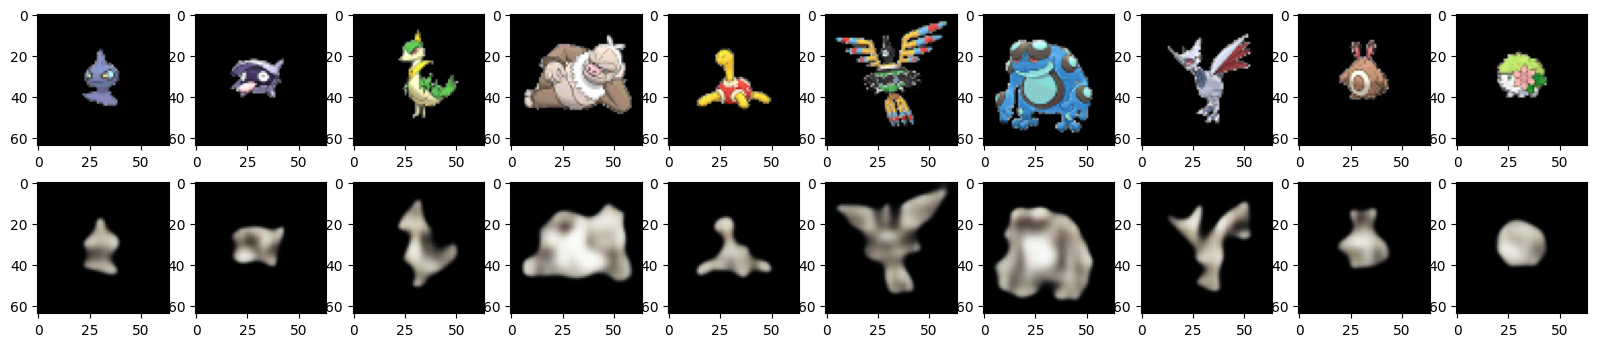

In [10]:
#test 데이터(디코더 이미지)와 train 데이터 비교
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=10,figsize=(20, 4))
plt.gray()
for indice, row in enumerate(ax):
    for indice2, col in enumerate(row):
        if indice == 0:
            col.imshow(X_test[indice2].reshape(64,64,3))
        else:
            col.imshow(decoded_imgs[indice2].reshape(64,64,3))

plt.show()